## MNIST-trained an Unsupervised Deep Convolutional Generative Adversarial Network of handwritten digits (DCGAN)

In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim

import matplotlib.animation as animation
from IPython.display import HTML
from torchvision import datasets, utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on device", device)

Training on device cuda


In [2]:
# number of subprocesses to use for data loading
num_workers = 4
# number of samples per batch to load
batch_size = 64
transform = transforms.ToTensor()

#train_data = datasets.MNIST(root = "data", download=True, train=True, transform=transform )

data_path = 'MNIST/processed/training.pt'
train_data = datasets.MNIST(root = data_path, download=True, train=True, transform=transform )

train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                           batch_size = batch_size, 
                                           num_workers = num_workers, 
                                           shuffle = True)


In [3]:
# depending on the batch size last batch might not have the batch_size num images
# need to consider the differentrce when generating labels for the lst batch!!!
print("batch size: ", batch_size)
print("number of batches: ", len(train_loader))
print("number of images in the last batch: ", len(train_loader.dataset) - batch_size*(len(train_loader)-1))

batch size:  64
number of batches:  938
number of images in the last batch:  32


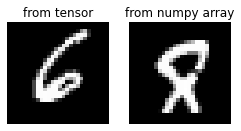

In [4]:
# get a single batch of training images:
dataiter = iter(train_loader)
images, labels = dataiter.next()

#to dsiplay as a tensor image permute the chanel as the last dim
plt.figure(figsize=(4,8))

plt.subplot(1,2,1)
plt.axis("off")
plt.title("from tensor")
plt.imshow(images[0].permute(1,2,0), cmap='gray')


#to display as a numpy array image squeezing out the chanel dim
img = np.squeeze(images[1])

plt.subplot(1,2,2)
plt.axis("off")
plt.title("from numpy array")
plt.imshow(img.numpy(), cmap='gray')

## DCGAN Model

*GAN* is comprise of two networks, a Generator and a Discriminator competing against each other. Generator's goal is to learn the distribution of the training dataset; it turns random noise input into images that look like a handwritten digit from the MNIST dataset. Simultaneously, the Discriminator learns to distinguish the fake images produced by the Generator from the genuine ones coming from the training dataset.

**DCGANs** are a class of convolutional GANs, where both the generator and discriminator networks are comprised of convolutional neural networks (CNNs).


![alt text](DCGAN_model.png "DCGAN model architecture")


* DCGAN is a more stable architecture for training generative adversarial networks

* DCGAN eliminate fully connected layers and replace all the max pooling layers with convolutional strides

* DCGAN trains with the Adam optimizer which is far better when training deep neural networks

* DCGAN uses batch normalization - normalize the inputs to each layer, for each training mini-batch as it flows through the network. Normalization makes the training process less sensitive to the scale of the features. Batch normalization solves the problem of ***covariate shift*** - variations in input value distributions between layers during training, by scaling values in each mini-batch by the mean and variance of that mini-batch [nn.BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html). Batch normalization limits the amount by which updating the parameters in the previous layers can affect the distribution of inputs received by the current layer. This decreases any unwanted interdependence between parameters across layers, which helps speed up the network training process and increase its robustness, especially when it comes to network parameter initialization.


### Set model hyperparameters

In [5]:
#set random seed for reproducibility
seed = 123
random.seed(seed)
torch.manual_seed(seed)

z_dim = 100 
batch_size = 64
num_epochs = 20

# number of channels of training image: 1 for graiscale, 3 for RGB images
n_ch = 1
# number of generator and discriminator feature maps
g_fm = 64
d_fm = 64

# Learning rate for optimizers
lr = 0.001
# Beta 1 hyperparameter for Adam optimizers
beta_1 = 0.5

# Create batch of latent vectors for visualizing the progress of the generator
fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)

### Generator

An fully connected linear layer reshapes a noise vector z that thakes in an random latent vector and reshapes it into a three-dimensional hidden layer with a small base (width × height) and large depth (chanels). Using transposed convolutions, the input is progressively reshaped such that its base grows while its depth decreases until the final layer where the shape of the generated image is 1 x 28 × 28.

![alt text](DCGAN_Generator.png "Generator model architecture")

After each transposed convolution layer batch noramlization is applied and the [Leaky ReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) as an activation function. Leaky ReLU has a small non-zero output for negative input and thus allows a gradients to flow backwards through the layer preventing the from dying out during training. The activation function applied to the output layer is *tahn* with output values in [-1, 1] which tends to produce sharper images than the *sigmoid* . NB: Need to scale the input images to have pixel values in the same range when training the discriminator.

In [6]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.deconv1 = nn.ConvTranspose2d(in_channels=z_dim, out_channels=g_fm*4, kernel_size=4, stride=1, padding=0, bias=False)
        self.batchn1 = nn.BatchNorm2d(g_fm*4)
        self.deconv2 = nn.ConvTranspose2d(in_channels=g_fm*4, out_channels=g_fm*2,  kernel_size=4, stride=2, padding=1, bias=False)
        self.batchn2 = nn.BatchNorm2d(g_fm*2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=g_fm*2, out_channels=g_fm,  kernel_size=4, stride=2, padding=1, bias=False)
        self.batchn3 = nn.BatchNorm2d(g_fm)
        self.deconv4 = nn.ConvTranspose2d(in_channels=g_fm, out_channels=n_ch,  kernel_size=2, stride=2, padding=2, bias=False)
        
        
    def forward(self, input):
        
        x = self.deconv1(input)
        x = self.batchn1(x)
        x = F.leaky_relu(x) # default negative_slope of 0.01
        x = self.deconv2(x)
        x = self.batchn2(x)
        x = F.leaky_relu(x)
        x = self.deconv3(x)
        x = self.batchn3(x)
        x = F.leaky_relu(x)
        x = self.deconv4(x)                                  
        
        output = torch.sigmoid(x)
        
        return output

### Discriminator

A convolutional network which takes 1x28x28 image, applies several convolutional layers and using sigmoid activation function, outputs a probability if the input image is real or fake. The input image is transformed such that its base (width × height) gets progressively smaller and its depth (channels) gets progressively deeper. On all convolutional layers Leaky ReLU activation function is applyed. Batch normalization is used on all convolutional layers except the firs one.

![alt text](DCGAN_Discriminator.png "Discriminator model architecture")

In [7]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=n_ch, out_channels=d_fm, kernel_size=2, stride=2, padding=2, bias=False)
        self.conv2 = nn.Conv2d(in_channels=d_fm, out_channels=d_fm*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchn1 = nn.BatchNorm2d(d_fm*2)
        self.conv3 = nn.Conv2d(in_channels=d_fm*2, out_channels=d_fm*4, kernel_size=4, stride=2, padding=1,bias=False)
        self.batchn2 = nn.BatchNorm2d(d_fm*4)
        self.conv4 = nn.Conv2d(in_channels=d_fm*4, out_channels=n_ch, kernel_size=4, stride=1, padding=0, bias=False)
        
    def forward(self, input):
        
        x = self.conv1(input)
        x = F.leaky_relu(x) # default negative_slope=0.01, inplace = False
        x = self.conv2(x)
        x = self.batchn1(x)
        x = F.leaky_relu(x)
        x = self.conv3(x)
        x = self.batchn2(x)
        x = F.leaky_relu(x)
        x = self.conv4(x)
        
        output = torch.sigmoid(x)
        
        return output
    

In [8]:
netG = Generator().to(device)
netD = Discriminator().to(device)

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
netG.apply(weights_init)
netD.apply(weights_init)        

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

In [10]:
#check if Generator is working with batch of random noise latent vectors
noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
print("random noise vector of size:", noise.size())
output = netG(noise)
print("generator output size:", output.size())

random noise vector of size: torch.Size([64, 100, 1, 1])
generator output size: torch.Size([64, 1, 28, 28])


In [11]:
# check if the Discriminator model runs
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = netD(images) #images[1].unsqueeze(0)

# sigmoid + binary_cross_entropy
def sigmoid(x): return (1 + (-x).exp()).reciprocal()

def binary_cross_entropy(x, y): return -(x.log()*y + (1-y)*(1-x).log()).mean()

loss = binary_cross_entropy(output.squeeze(), labels)
print("Loss of a batch of real images: ", loss)

Loss of a batch of real images:  tensor(4.2566, device='cuda:0', grad_fn=<NegBackward>)


### Loss Functions

Use the Binary Cross Entropy Loss, [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html).

\begin{equation*}
\ l(x, y)=L= ( l_1, l_2,  ... , l_N ) ^T, 
\        l= - [y_n.log x_n + (1 - y_n).log(1-x_n)]
\end{equation*}

This function provides the calculation of both log components log(D(x))
 and log(1−D(G(z))). We can specify what part of the BCE equation to use with the y input, so changing the G and D labels makes the computation of the different loss functions happen. 

In GAN papers, the loss function to optimize G is min(log(1-D(G(z)))), but in practice max(log(D(G(z)))) is used.

because the first formulation has vanishing gradients early on



In [12]:
#init the BCELoss function
loss_fn = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

### Optimizers

Generator and Discriminator get updated separetly so two separate Adam Optimizers are used 

In [13]:
# Set up Adam optimizers for the Generator and Discriminator
optimizerG= optim.Adam(netG.parameters(), lr=lr, betas=(beta_1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta_1, 0.999))

### Training

#### Train the Discriminator

Training the discriminator is to maximize the probability of correctly classifying a given input image as real or fake, thus maximizing *log(D(x))+log(1−D(G(z)))*, which if use two separate mini batches results in the following steps: 

1. Construct a batch of real samples from the training set, forward   pass through D, calculate the loss *log(D(x))*, then calculate the gradients in a backward pass. 

2. Construct a batch of fake samples with the current generator, forward pass this batch through D, calculate the loss *log(1−D(G(z)))*, and accumulate the gradients with a backward pass. 
 
3. With the gradients accumulated from both the all-real and all-fake batches call the Discriminator’s optimizer.


#### Train the Generator

Train the Generator by minimizing *log(1−D(G(z)))* in an effort to generate better fakes. But since this does not provide sufficient gradients we intead maximize *log(D(G(z)))*: 

1. Classify the Generator output from training the Dprevious part with the Discriminator, computing G’s loss using real labels as GT, this allows us to use the *log(x)* part of the BCELoss, rather than the *log(1−x)*

2. Compute G’s gradients in a backward pass

3. Update G’s parameters with an optimizer step


#### Training statistics

  * Loss_D - discriminator loss calculated as the sum of losses for the all real and all fake batches *(log(D(x))+log(D(G(z))))*
  * Loss_G - generator loss calculated as *log(D(G(z)))*
  * *D(x)* - the average discriminator output across the batch for the all real batch
  * *D(G(z))* - average discriminator outputs for the all fake batch. The first number is before D is updated and the second number is after D is updated
  
  
####   Tracking the progress of Generator

At the end of each epoch push our fixed_noise batch through the generator to visually track the progress of G’s training.


Generated images at Epoch  1


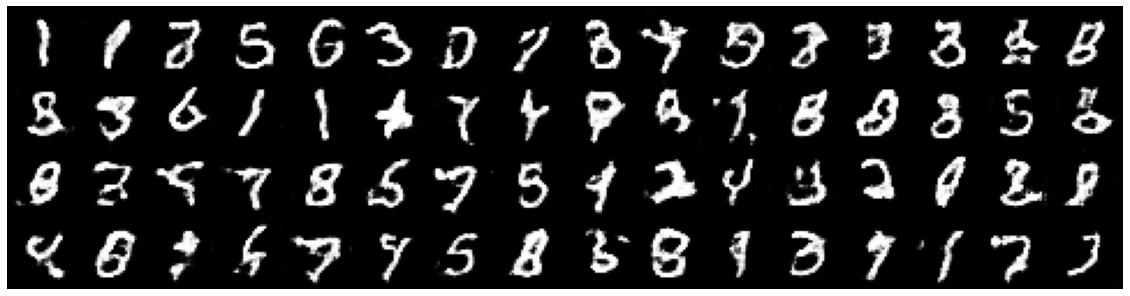

 Avg. Discriminator loss: 0.6818, Avg Generator loss: 3.3998


Generated images at Epoch  2


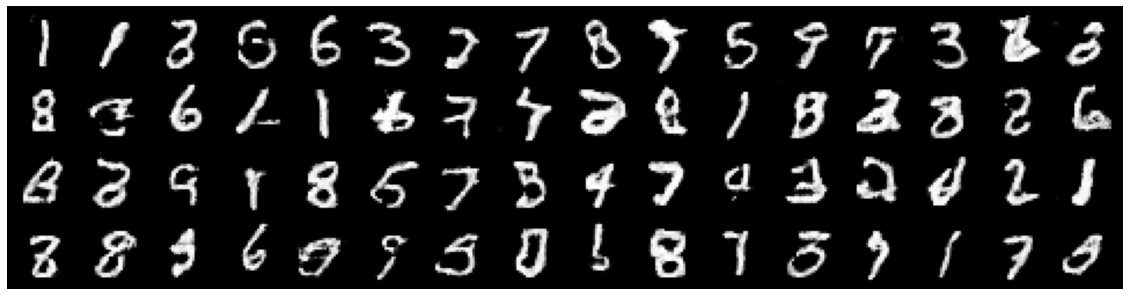

 Avg. Discriminator loss: 0.6684, Avg Generator loss: 3.0305


Generated images at Epoch  3


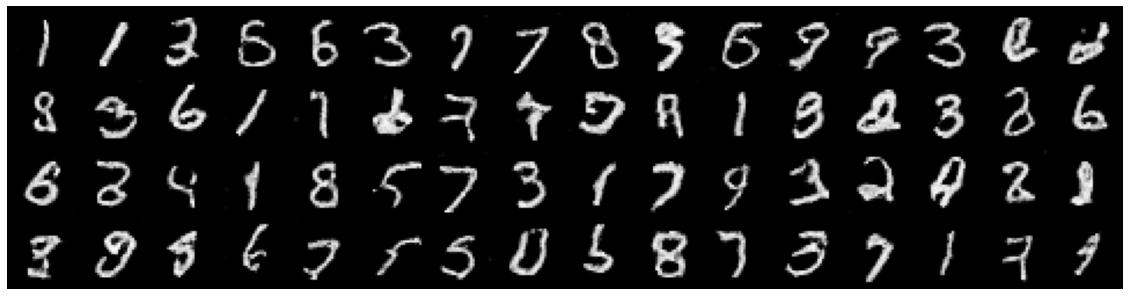

 Avg. Discriminator loss: 0.6307, Avg Generator loss: 3.0298


Generated images at Epoch  4


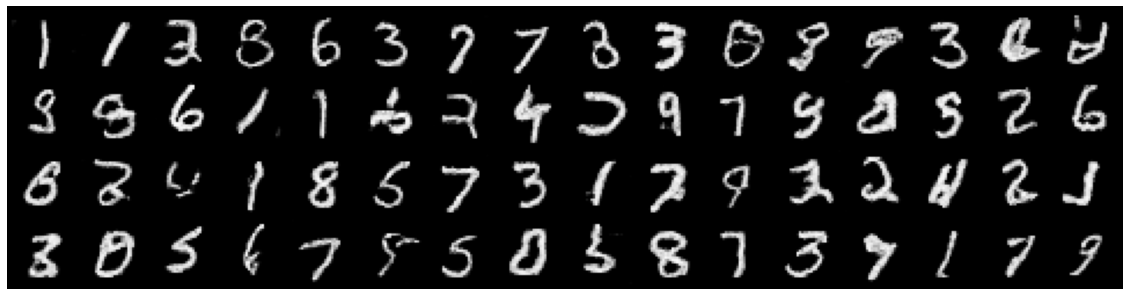

 Avg. Discriminator loss: 0.5993, Avg Generator loss: 3.0982


Generated images at Epoch  5


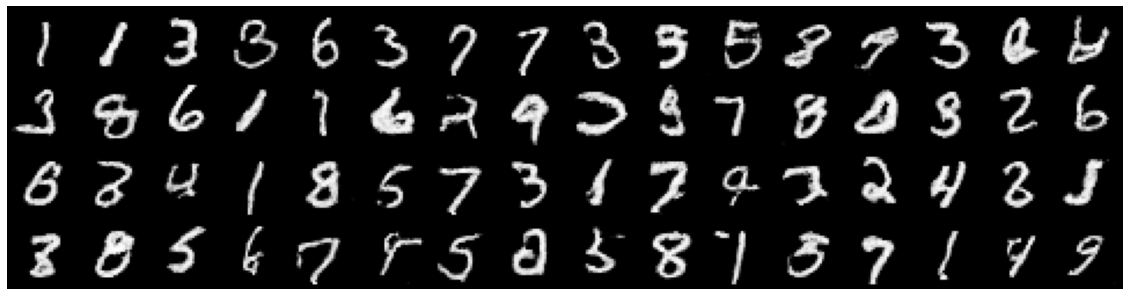

 Avg. Discriminator loss: 0.5672, Avg Generator loss: 3.1913


Generated images at Epoch  6


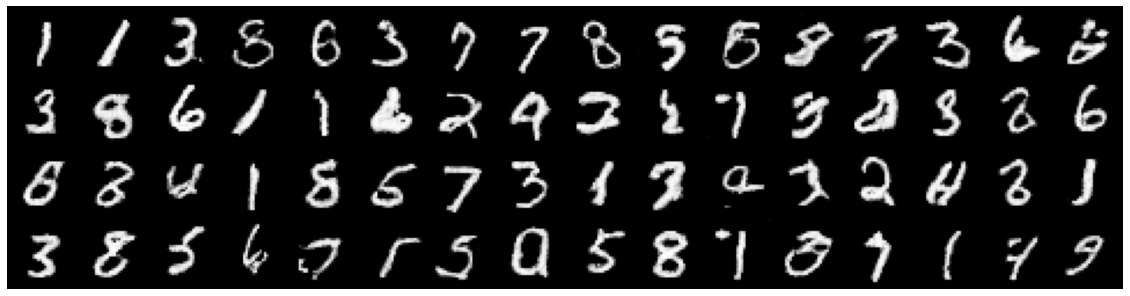

 Avg. Discriminator loss: 0.5411, Avg Generator loss: 3.2932


Generated images at Epoch  7


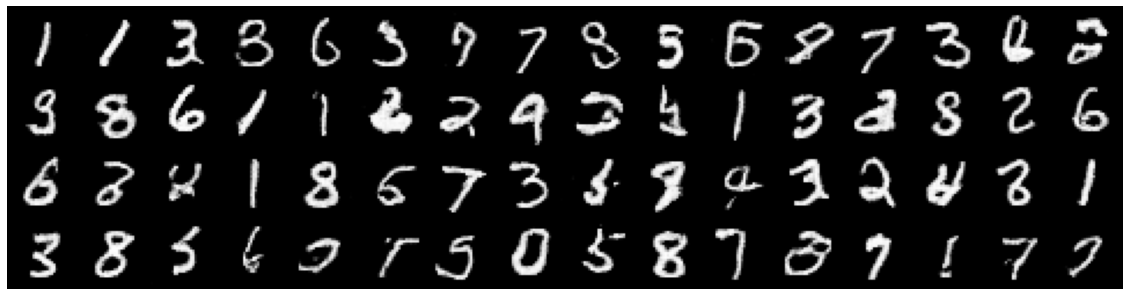

 Avg. Discriminator loss: 0.5176, Avg Generator loss: 3.3969


Generated images at Epoch  8


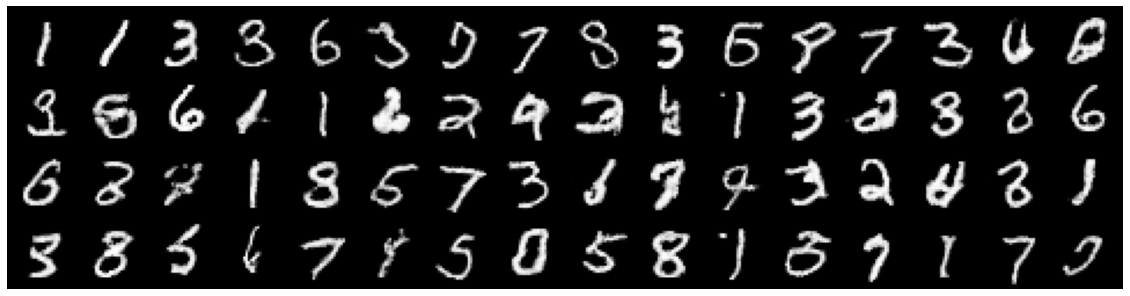

 Avg. Discriminator loss: 0.5011, Avg Generator loss: 3.4833


Generated images at Epoch  9


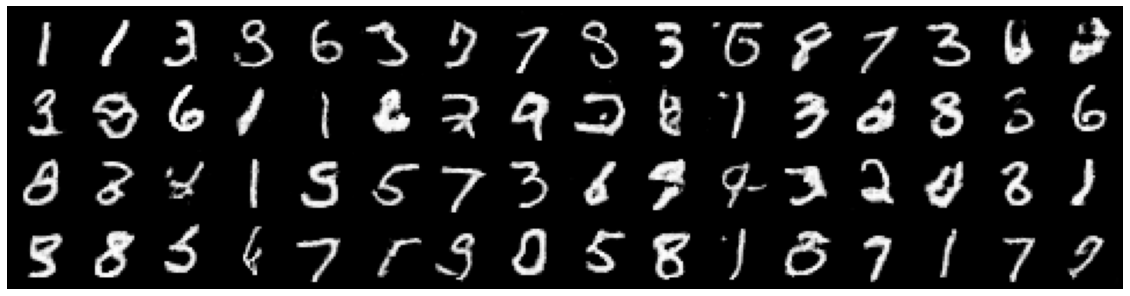

 Avg. Discriminator loss: 0.4813, Avg Generator loss: 3.5603


Generated images at Epoch  10


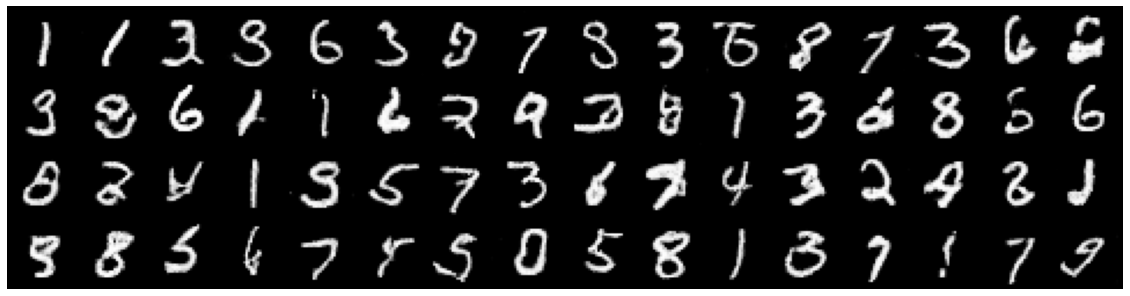

 Avg. Discriminator loss: 0.4664, Avg Generator loss: 3.6382


Generated images at Epoch  11


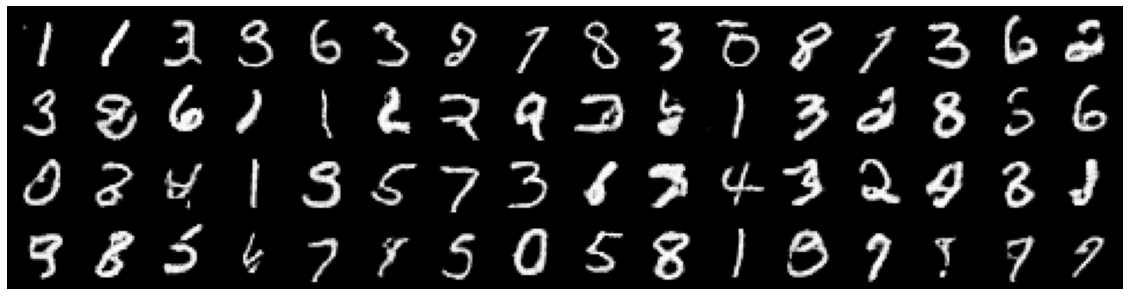

 Avg. Discriminator loss: 0.4533, Avg Generator loss: 3.7100


Generated images at Epoch  12


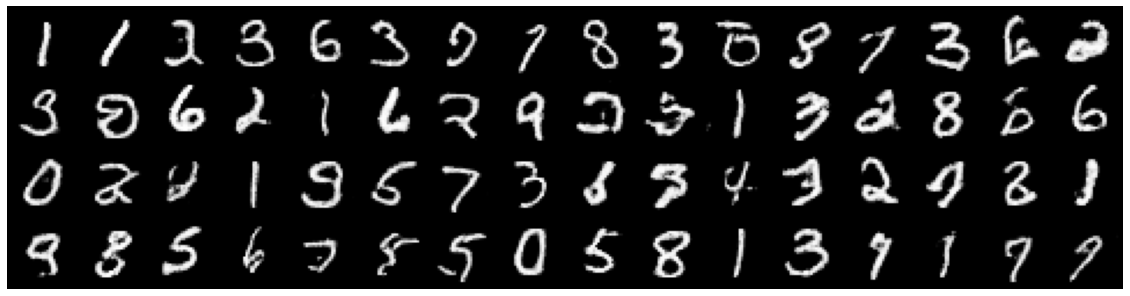

 Avg. Discriminator loss: 0.4407, Avg Generator loss: 3.7886


Generated images at Epoch  13


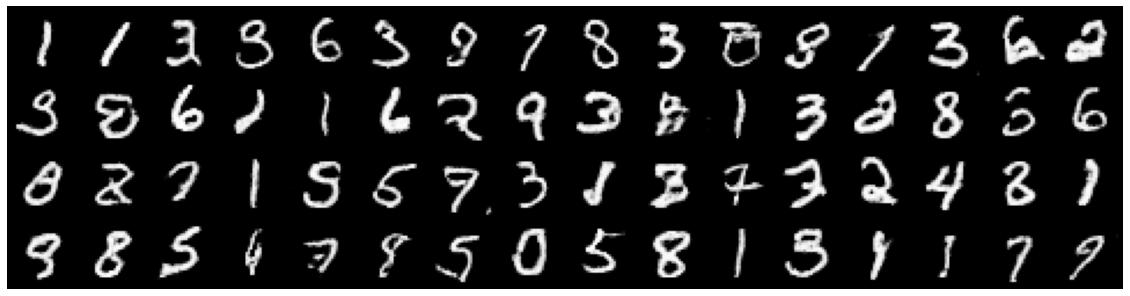

 Avg. Discriminator loss: 0.4262, Avg Generator loss: 3.8590


Generated images at Epoch  14


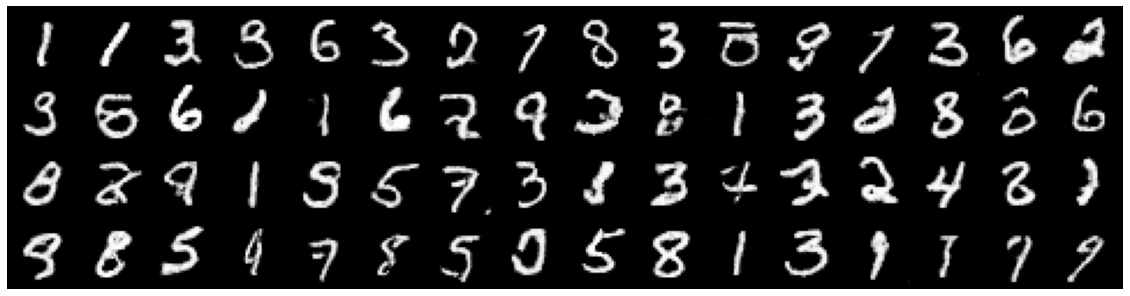

 Avg. Discriminator loss: 0.4187, Avg Generator loss: 3.9155


Generated images at Epoch  15


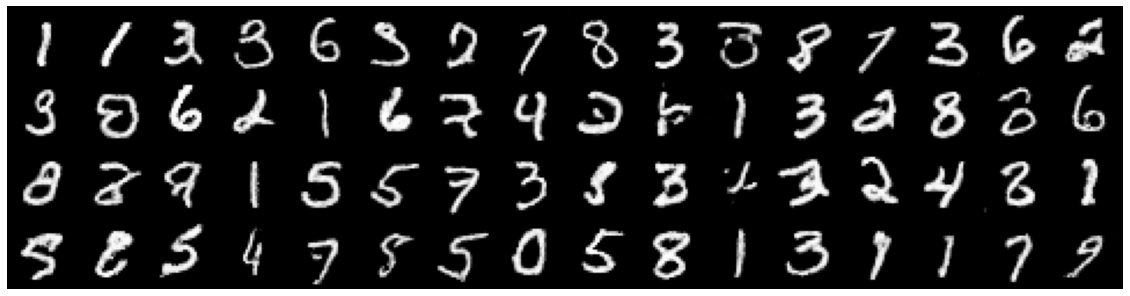

 Avg. Discriminator loss: 0.4090, Avg Generator loss: 3.9795


Generated images at Epoch  16


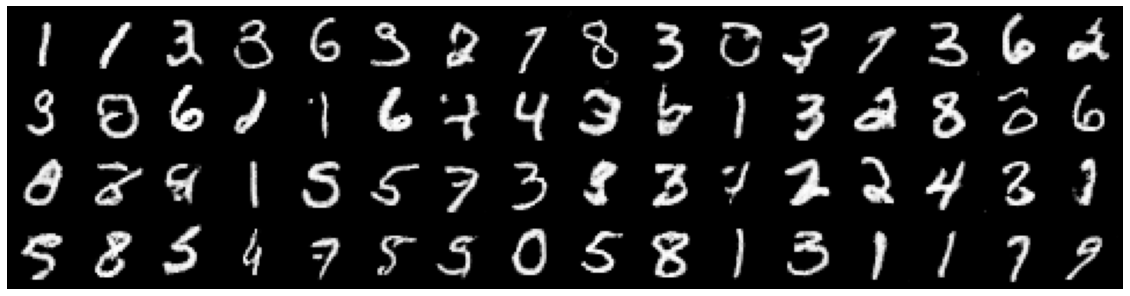

 Avg. Discriminator loss: 0.3976, Avg Generator loss: 4.0422


Generated images at Epoch  17


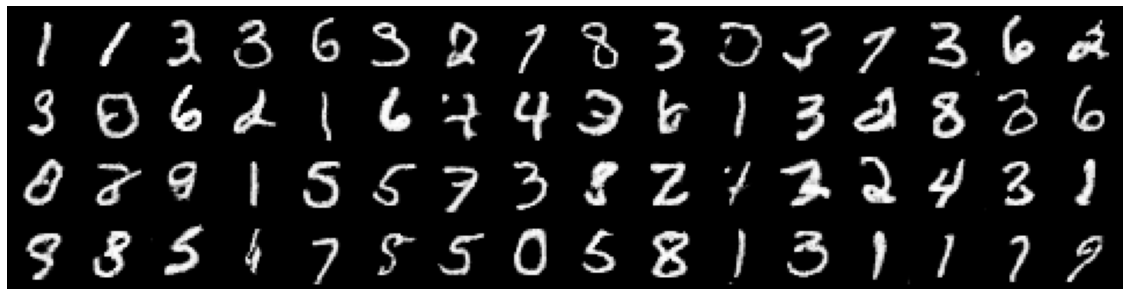

 Avg. Discriminator loss: 0.3884, Avg Generator loss: 4.1026


Generated images at Epoch  18


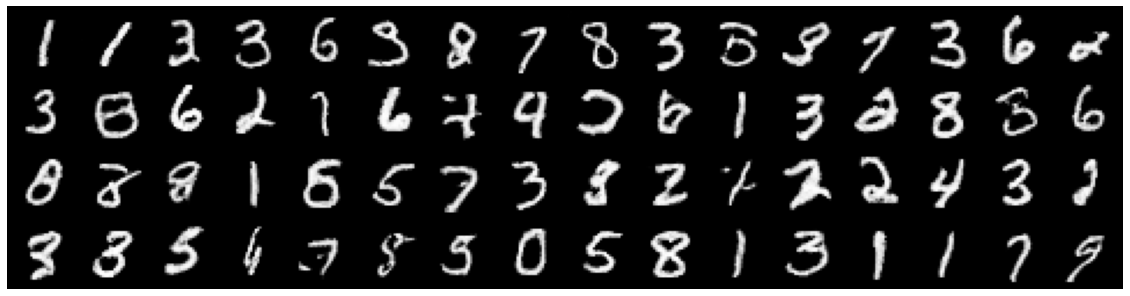

 Avg. Discriminator loss: 0.3803, Avg Generator loss: 4.1594


Generated images at Epoch  19


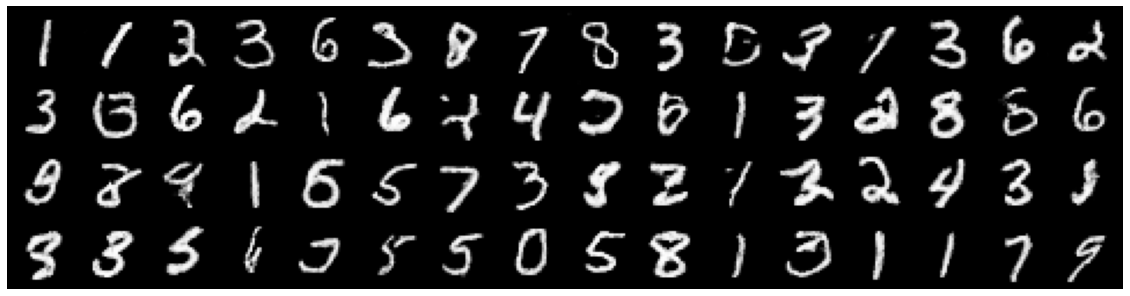

 Avg. Discriminator loss: 0.3732, Avg Generator loss: 4.2183


Generated images at Epoch  20


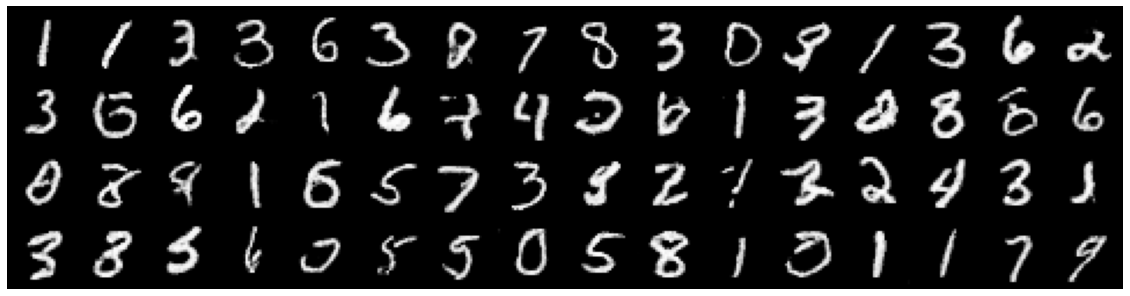

 Avg. Discriminator loss: 0.3662, Avg Generator loss: 4.2667



In [14]:
# Lists to keep track of progress
G_losses = []
D_losses = []

fixed_fake_imgs =[]

print_every = 500

# train the GAN network
netD.train()
netG.train()

fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)

for epoch in range(num_epochs):
        
    #for each batch in the train loader
    for batch_idx, batch_data in enumerate(train_loader):
        
        real_imgs, _ = batch_data
        real_imgs = real_imgs.to(device)
           
        num_imgs = real_imgs.size()[0]
               
        ###############################################################
        #                                                             #
        # Update Discirminator: maximize log(D(x)) + log(1 - D(G(z))) #
        #                                                             #
        ###############################################################
                  
        netD.zero_grad()
              
        #################### Train with real images ###################
     
        labels = torch.full((num_imgs,), real_label, dtype=torch.float, device = device)
        
        output = netD(real_imgs)
        
        # compute the Discriminator losses on real images
        real_lossD =  loss_fn(output.squeeze(), labels)
        
        # compute the gradient of the real images loss w.r.t. Discriminator model parameters
        real_lossD.backward(retain_graph=True)
        
                
        ################### Train with fake images ########################
        
        # generate batch of latent vectors - tensors with random numbers from the standart normal distr 
        noise = torch.randn(num_imgs, z_dim, 1, 1, device=device)
        
        # generate batch of fake images 
        fake_imgs = netG(noise)
        
        labels = torch.full((num_imgs,), fake_label, dtype=torch.float, device = device)
        
        # classify the batch of fake images with the Discriminator
        output = netD(fake_imgs) 
        
        # compute the Discriminator losses on batch of fake images
        fake_lossD =  loss_fn(output.squeeze(), labels)
        
        # compute the gradient of the fake images loss w.r.t. Discriminator model parameters
        fake_lossD.backward(retain_graph=True)
        
        # add up losses from classifing a batch of real and  a batch of fake images
        lossD = real_lossD + fake_lossD
        
        # update the Discriminator weights
        optimizerD.step()
        
           
        ###############################################################
        #                                                             #
        #           Update Generator: maximize log(D(G(z)))           #
        #                                                             #
        ###############################################################
        
        netG.zero_grad()
            
        # since the generator's goal is to get netD(fake_images) = 1, we flip the labels for computing Generator's loss
        labels = torch.full((num_imgs,), real_label, dtype=torch.float, device = device)    
        
        # perform another forward pass with the batch of fake images through the Discriminator, after it was updated in the previus step
        output = netD(fake_imgs)
        
        # compute the Generator's loss on this output
        lossG = loss_fn(output.squeeze(), labels)
        
        # compute the gradient of the fake images (called "real") loss w.r.t. Generator model parameters
        lossG.backward()
        
        # update the Generator weights
        optimizerG.step()
        
        
        ###############################################################
        #                                                             #
        #                    Output training stats                    #
        #                                                             #
        ###############################################################
        
        # print out training stats every chosen number of batches
        #if batch_idx % print_every == 0:
            
            #print('Epoch {}/{}  Batch {}/{}'.format(epoch +1, num_epochs, batch_idx, len(train_loader)))
            #print('-'*30)
            #print('discriminator loss: {:6.4f}, generator loss: {:6.4f}'.format(lossD.item(), lossG.item()))
            #print()
            
        # save losses for plotting
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())
        
    ############################ after each epoch  #########################
    print()
    # check how the Generator is doing by displaing the fixed noise generated fake images
    netG.eval()
    
    with torch.no_grad():
        generated = netG(fixed_noise).detach().cpu()
        image_grid = torchvision.utils.make_grid(generated, nrow=16)
        
        print("Generated images at Epoch ", epoch + 1)
        plt.figure(figsize=(20,10))
        plt.imshow(image_grid.permute(1, 2, 0))
        plt.axis("off")
        plt.pause(0.05)

    print(' Avg. Discriminator loss: {:6.4f}, Avg Generator loss: {:6.4f}'.format(sum(D_losses)/len(D_losses), sum(G_losses)/len(G_losses)))
    print()
    
    netG.train()    
        

Comparison of the fake, generated images with a batch of real training images:

(-0.5, 481.5, 121.5, -0.5)

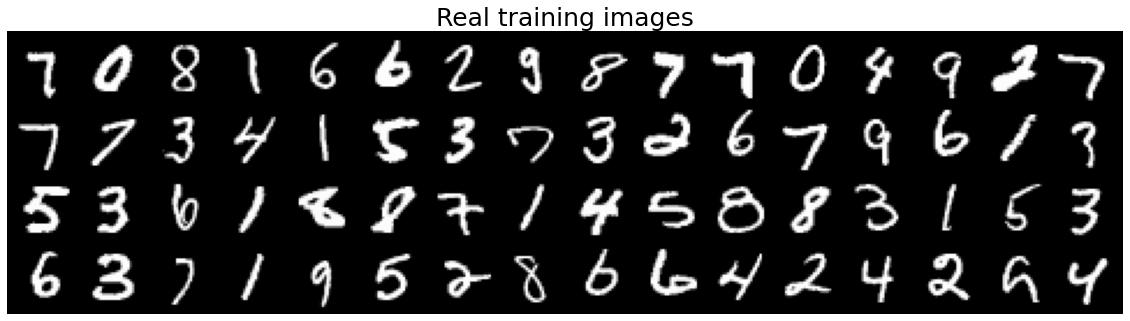

In [15]:
dataiter = iter(train_loader)
images, _ = dataiter.next()

image_grid = torchvision.utils.make_grid(images, nrow=16)

plt.figure(figsize=(20,10))
plt.title("Real training images", fontsize=25)
plt.imshow(image_grid.permute(1, 2, 0))
plt.axis("off")

### Results

Display three different results:

  * Loss vs training itterations for the Discriminator and Generator
  * Generator's output on the fixed noise batch for every epoch
  * Batch of real and generated fake images

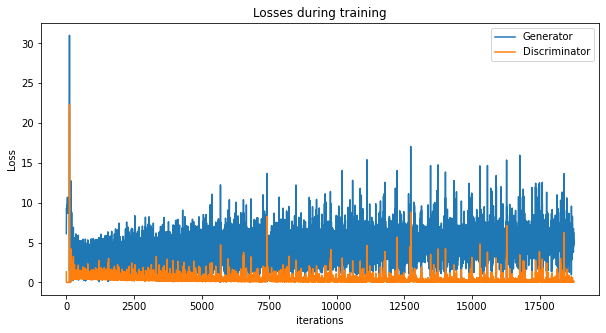

In [16]:
plt.figure(figsize=(10,5))
plt.title("Losses during training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()